In [ ]:
"""
Goal: To analyze the difference between P2L and L2P regression outcomes
"""

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from scipy.stats import pearsonr
from datetime import datetime
import random

In [2]:
# Load data
date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
l2p_regression = pd.read_feather("../data/2025-12-05-08:26:09_l2p_regression_gender_age_pckyr_race.feather")
p2l_regression = pd.read_feather("../data/2025-12-05-08:26:09_p2l_regression_gender_age_pckyr_race.feather")
l2p_merged = pd.read_feather("../data/2025-12-04-16:39:25_l2p_merged.feather")
p2l_merged = pd.read_feather("../data/2025-12-04-18:54:47_p2l_merged.feather")
pheno_df = pd.read_csv("../data/pheno_df.csv")


In [3]:
# Preprocess data
l2p_regression.index = l2p_regression['edge']
p2l_regression.index = p2l_regression['edge']
p2l_regression = p2l_regression.reindex(l2p_regression.index)
p2l_regression = p2l_regression.drop(columns=["edge"])
l2p_regression = l2p_regression.drop(columns=["edge"])

l2p_sig_edges = l2p_regression[l2p_regression['p_value'] < 0.01]
p2l_sig_edges = p2l_regression[p2l_regression['p_value'] < 0.01]



In [83]:
p2l_avg_edge_weight = p2l_merged.mean(numeric_only=True)[0:326457]
l2p_avg_edge_weight = l2p_merged.mean(numeric_only=True)[0:326457]

l2p_avg_edge_weight = l2p_avg_edge_weight.reindex(p2l_avg_edge_weight.index)


p2l_sd_edge_weight = p2l_merged.std(numeric_only=True)[0:326457]
l2p_sd_edge_weight = l2p_merged.std(numeric_only=True)[0:326457]

l2p_sd_edge_weight = l2p_sd_edge_weight.reindex(p2l_sd_edge_weight.index)


In [5]:
# Define all_merged
all_merged = l2p_regression.merge(
    p2l_regression[['beta_score', 'p_value']],
    left_index=True,
    right_index=True,
    suffixes=('_l2p', '_p2l') 
)

all_merged['beta_score_diff'] = all_merged['beta_score_l2p'] - all_merged['beta_score_p2l']
all_merged['p_value_diff'] = all_merged['p_value_l2p'] - all_merged['p_value_p2l']
all_merged[['TF', 'Gene']] = all_merged.index.to_series().str.split('_', expand=True)
all_merged['z_score_l2p'] = (all_merged['beta_score_l2p'] - all_merged['beta_score_l2p'].mean()) / all_merged['beta_score_l2p'].std()
all_merged['z_score_p2l'] = (all_merged['beta_score_p2l'] - all_merged['beta_score_p2l'].mean()) / all_merged['beta_score_p2l'].std()
all_merged['z_score_diff'] = all_merged['z_score_l2p'] - all_merged['z_score_p2l']
all_merged['l2p_rank'] = all_merged['beta_score_l2p'].rank(ascending=True)
all_merged['p2l_rank'] = all_merged['beta_score_p2l'].rank(ascending=True)
all_merged['rank_diff'] = all_merged['l2p_rank'] - all_merged['p2l_rank']
all_merged['abs_rank_diff'] = abs(all_merged['l2p_rank'] - all_merged['p2l_rank'])

### MAKE SURE TO UPDATE WHEN NEEDED ###
all_merged.to_feather("../data/" + date + "_regression_all_merged_gender_and_age.feather")

In [6]:
# Define sig_merged
sig_merged = l2p_sig_edges.merge(
    p2l_sig_edges[['beta_score', 'p_value']],
    left_index=True, 
    right_index=True,
    suffixes=('_l2p', '_p2l') 
)

sig_merged['beta_score_diff'] = sig_merged['beta_score_l2p'] - sig_merged['beta_score_p2l']
sig_merged['p_value_diff'] = sig_merged['p_value_l2p'] - sig_merged['p_value_p2l']
sig_merged

,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff
edge,,,,,,
ALX3_MIR1-2,-0.355813,0.005126,-0.121719,0.000653,-0.234095,0.004473
NOTO_MIR1-2,-0.355813,0.005126,-0.121719,0.000653,-0.234095,0.004473
ZSCAN31_MIR1-2,0.303985,0.001312,0.090435,0.000180,0.213550,0.001132
CENPBD1_MIR100,0.564639,0.000288,0.167149,0.007348,0.397490,-0.007060
MYF5_MIR100,-0.276071,0.006188,-0.079654,0.008960,-0.196417,-0.002771
...,...,...,...,...,...,...
RHOXF1_MIR99B,0.263198,0.006256,0.054549,0.006645,0.208649,-0.000388
RUNX1_MIR99B,-0.283857,0.004529,-0.059875,0.005009,-0.223982,-0.000480
ZBED1_MIR99B,0.322077,0.004914,0.072017,0.002774,0.250059,0.002139


In [7]:
at_least_one_sig = all_merged[(all_merged['p_value_l2p'] < 0.01) | (all_merged['p_value_p2l'] < 0.01)]

In [8]:
significant_z_score_difference = all_merged[abs(all_merged['z_score_diff']) > 3]
significant_z_score_difference['abs_z_score_diff'] = abs(significant_z_score_difference['z_score_diff'])
significant_z_score_difference_sorted = significant_z_score_difference.sort_values("abs_z_score_diff", ascending=False)
analyze = significant_z_score_difference_sorted.index[0:10]

/var/folders/bq/226cskms46n2bgsczmlf7h800000gn/T/ipykernel_45460/3811418233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_z_score_difference['abs_z_score_diff'] = abs(significant_z_score_difference['z_score_diff'])


In [9]:
very_diff_p_value = all_merged[abs(all_merged['p_value_diff']) > 0.8]
very_diff_beta = all_merged[abs(all_merged['beta_score_diff']) > 0.5]

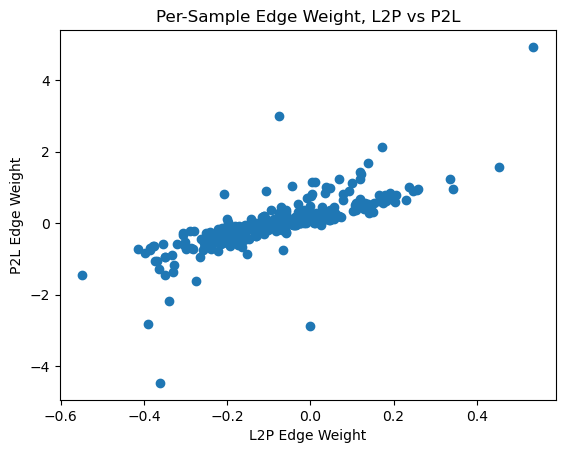

In [78]:
# UPDATE TO MAKE IT SO THAT ITS IN THE SAME ORDER
# Analyze z-score diff P2L vs L2P
edge = random.choice(l2p_merged.columns)

plt.scatter(l2p_merged[edge], p2l_merged[edge])
plt.xlabel("L2P Edge Weight")
plt.ylabel("P2L Edge Weight")
plt.title(f"Per-Sample Edge Weight, L2P vs P2L")
plt.show()

Text(0, 0.5, 'Number of Edges')

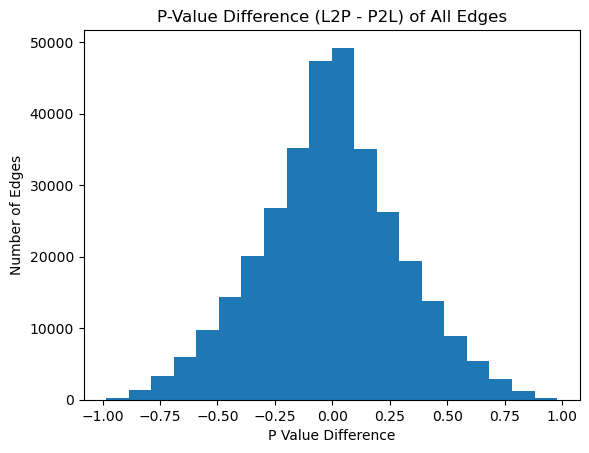

In [11]:
plt.hist(all_merged['p_value_diff'], bins = 20)
plt.title("P-Value Difference (L2P - P2L) of All Edges")
plt.xlabel("P Value Difference")
plt.ylabel("Number of Edges")

Text(0, 0.5, 'P2L P-Value')

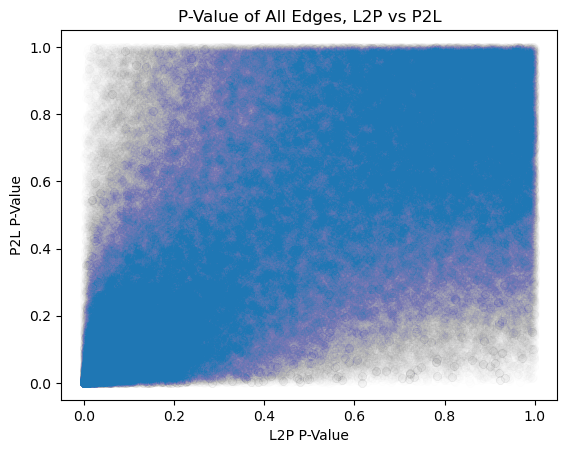

In [12]:
plt.scatter(all_merged['p_value_l2p'], all_merged['p_value_p2l'], alpha=0.005)
plt.title("P-Value of All Edges, L2P vs P2L")
plt.xlabel("L2P P-Value")
plt.ylabel("P2L P-Value")

Text(0, 0.5, 'P2L Beta Score')

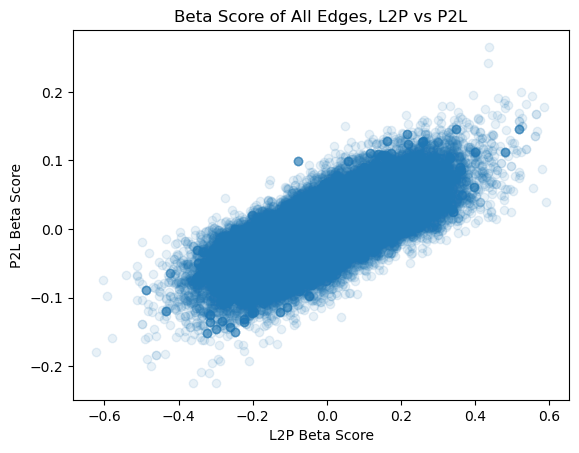

In [13]:
plt.scatter(all_merged['beta_score_l2p'], all_merged['beta_score_p2l'], alpha=0.1)
plt.title("Beta Score of All Edges, L2P vs P2L")
plt.xlabel("L2P Beta Score")
plt.ylabel("P2L Beta Score")

Text(0.5, 1.0, 'Difference in Beta Score of Edges Significant in L2P and P2l')

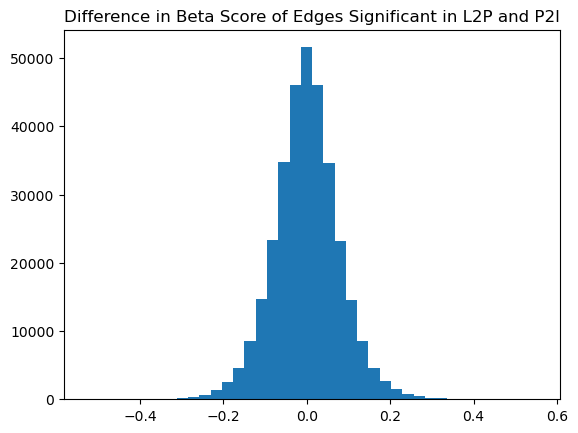

In [71]:
plt.hist(all_merged['beta_score_diff'], bins=40)
plt.title("Difference in Beta Score of Edges Significant in L2P and P2l")

Text(0.5, 1.0, 'Difference in P-Value of Edges Significant in Both L2P and P2l')

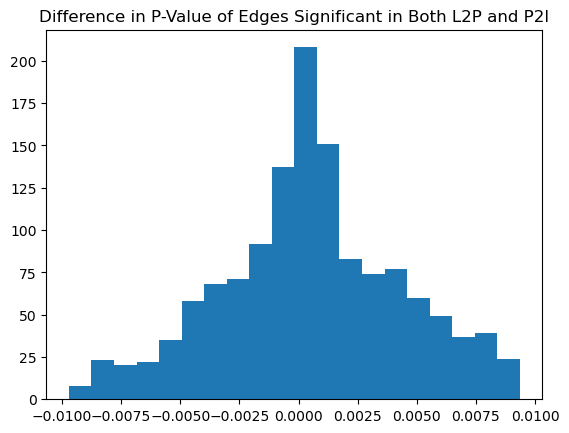

In [15]:
plt.hist(sig_merged['p_value_diff'], bins=20)
plt.title("Difference in P-Value of Edges Significant in Both L2P and P2l")

In [16]:
sig_merged[abs(sig_merged['beta_score_diff']) > 0.5]

,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff
edge,,,,,,


Text(0, 0.5, 'P2L Beta Score')

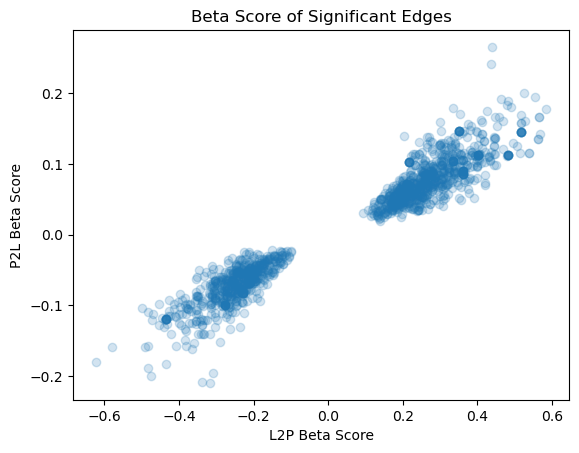

In [17]:
plt.scatter(sig_merged['beta_score_l2p'], sig_merged['beta_score_p2l'], alpha=0.2)
plt.title("Beta Score of Significant Edges")
plt.xlabel("L2P Beta Score")
plt.ylabel("P2L Beta Score")

Text(0, 0.5, 'P2L P-Value')

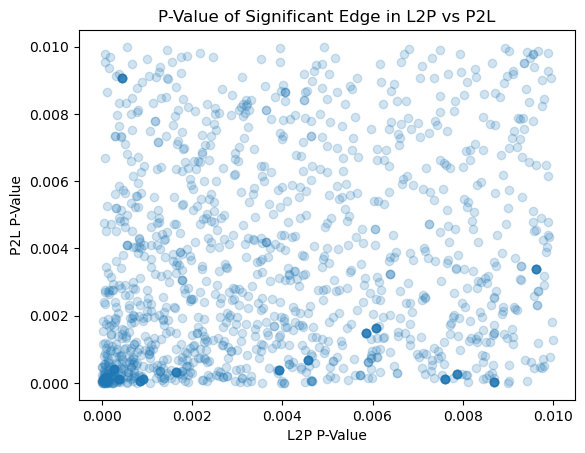

In [19]:
plt.scatter(sig_merged['p_value_l2p'], sig_merged['p_value_p2l'], alpha=0.2)
plt.title("P-Value of Significant Edge in L2P vs P2L")
plt.xlabel("L2P P-Value")
plt.ylabel("P2L P-Value")

In [20]:
print(l2p_sd_edge_weight[1000:1050])


CDC5L_MIR1-2      0.093336
CDX1_MIR1-2       0.107332
CDX2_MIR1-2       0.107332
CDX4_MIR1-2       0.096143
CEBPE_MIR1-2      0.099665
CENPB_MIR1-2      0.090713
CENPBD1_MIR1-2    0.074972
CIC_MIR1-2        0.120065
CLOCK_MIR1-2      0.103048
CPEB1_MIR1-2      0.131432
CREB1_MIR1-2      0.078234
CREB3_MIR1-2      0.094520
CREB3L1_MIR1-2    0.097986
CREB3L4_MIR1-2    0.092475
CREB5_MIR1-2      0.110155
CREBL2_MIR1-2     0.108669
CREM_MIR1-2       0.114658
CTCF_MIR1-2       0.102612
CTCFL_MIR1-2      0.111224
CUX1_MIR1-2       0.099755
CUX2_MIR1-2       0.096367
CXXC5_MIR1-2      0.094197
DBP_MIR1-2        0.079729
DBX1_MIR1-2       0.087545
DLX1_MIR1-2       0.103265
DLX2_MIR1-2       0.117848
DLX3_MIR1-2       0.093560
DLX4_MIR1-2       0.117848
DLX5_MIR1-2       0.111034
DLX6_MIR1-2       0.083582
DMBX1_MIR1-2      0.097501
DMRT1_MIR1-2      0.116780
DMRT2_MIR1-2      0.107390
DMRT3_MIR1-2      0.077903
DMRTA1_MIR1-2     0.078375
DMRTA2_MIR1-2     0.123012
DMRTB1_MIR1-2     0.121688
D

In [21]:
print(p2l_sd_edge_weight[1000:1050])

ALX4_MIR889        0.460224
ALX4_MIR9-1        0.364656
ALX4_MIR9-2        0.565856
ALX4_MIR9-3        0.476214
ALX4_MIR92B        0.549673
ALX4_MIR93         0.302513
ALX4_MIR940        0.364510
ALX4_MIR941-1      0.323267
ALX4_MIR941-3      0.261642
ALX4_MIR941-4      0.357162
ALX4_MIR942        0.834284
ALX4_MIR944        0.543350
ALX4_MIR95         0.742024
ALX4_MIR96         0.357371
ALX4_MIR98         0.506932
ALX4_MIR99A        0.682409
ALX4_MIR99B        0.662179
ARGFX_MIR1-1       0.463381
ARGFX_MIR1-2       0.272877
ARGFX_MIR100       0.355674
ARGFX_MIR101-1     0.324213
ARGFX_MIR101-2     0.339162
ARGFX_MIR106A      0.319023
ARGFX_MIR106B      0.492692
ARGFX_MIR107       0.370343
ARGFX_MIR10A       0.355853
ARGFX_MIR10B       0.278597
ARGFX_MIR1180      0.292289
ARGFX_MIR1185-1    0.354646
ARGFX_MIR1185-2    0.374623
ARGFX_MIR1226      0.293203
ARGFX_MIR1247      0.363401
ARGFX_MIR1248      0.403720
ARGFX_MIR1249      0.411339
ARGFX_MIR125A      0.497307
ARGFX_MIR126       0

In [22]:
# CHECK ORDER OF EDGES!!!!!!!!

# plt.scatter(l2p_sd_edge_weight, p2l_sd_edge_weight, alpha=0.2)
# plt.title("Standard Deviation of All Edge Weights, L2P vs P2L")
# m, b = np.polyfit(l2p_sd_edge_weight, p2l_sd_edge_weight, 1)
# plt.plot(l2p_sd_edge_weight, m*l2p_sd_edge_weight + b, color = "red")
# plt.text(0.05, 1.2, f"Slope = {m}")
# plt.xlabel("L2P Edge Weight Standard Deviation")
# plt.ylabel("P2L Edge Weight Standard Deviation")

Text(0, 0.5, 'Edge Weight, P2L')

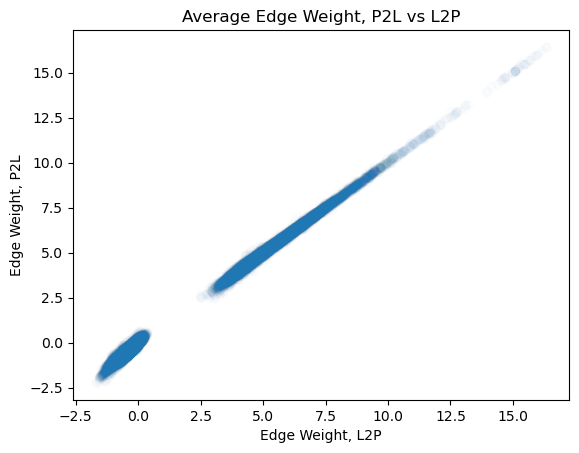

In [84]:
plt.scatter(l2p_avg_edge_weight, p2l_avg_edge_weight, alpha=0.01)
plt.title("Average Edge Weight, P2L vs L2P")
plt.xlabel("Edge Weight, L2P")
plt.ylabel("Edge Weight, P2L")

Text(0.5, 1.0, 'L2P vs P2L Average Edge Weight (Average < 2)')

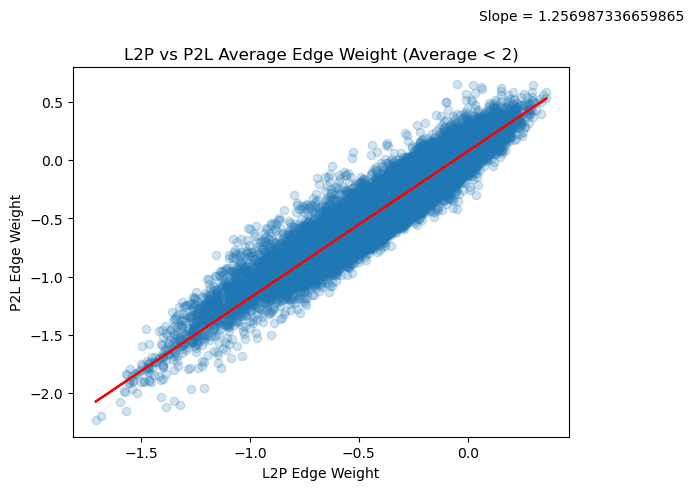

In [86]:
mask = (p2l_avg_edge_weight < 2) & (l2p_avg_edge_weight < 2)
plt.scatter(l2p_avg_edge_weight[mask], p2l_avg_edge_weight[mask], alpha = 0.2)
m, b = np.polyfit(l2p_avg_edge_weight[mask], p2l_avg_edge_weight[mask], 1)
plt.plot(l2p_avg_edge_weight[mask], m*l2p_avg_edge_weight[mask] + b, color = "red")
plt.xlabel("L2P Edge Weight")
plt.ylabel("P2L Edge Weight")
plt.text(0.05, 1.2, f"Slope = {m}")
plt.title("L2P vs P2L Average Edge Weight (Average < 2)")

(array([3.09304e+05, 9.50000e+02, 7.68000e+02, 8.87700e+03, 4.94400e+03,
        1.15600e+03, 3.16000e+02, 8.30000e+01, 1.20000e+01, 4.70000e+01]),
 array([-1.70856847,  0.09665068,  1.90186983,  3.70708898,  5.51230813,
         7.31752728,  9.12274643, 10.92796558, 12.73318472, 14.53840387,
        16.34362302]),
 <BarContainer object of 10 artists>)

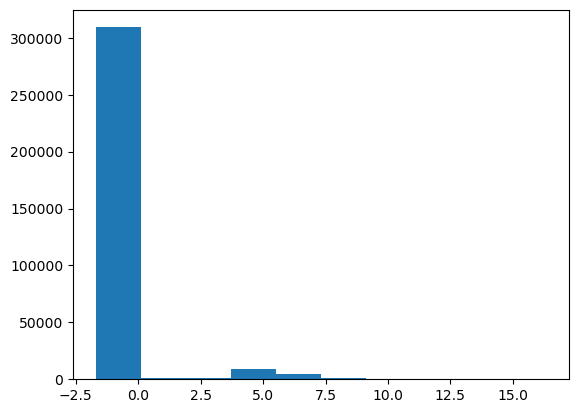

In [87]:
plt.hist(l2p_avg_edge_weight)

Text(0, 0.5, 'P-Value Difference')

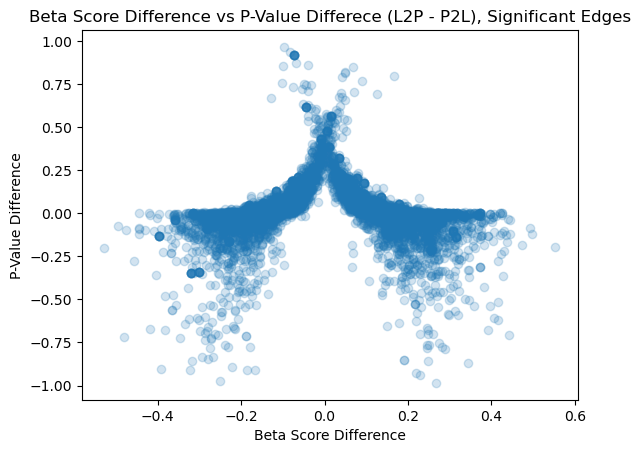

In [26]:
plt.scatter(at_least_one_sig['beta_score_diff'], at_least_one_sig['p_value_diff'], alpha=0.2)
plt.title("Beta Score Difference vs P-Value Differece (L2P - P2L), Significant Edges")
plt.xlabel("Beta Score Difference")
plt.ylabel("P-Value Difference")

Text(0, 0.5, 'P-Value Difference')

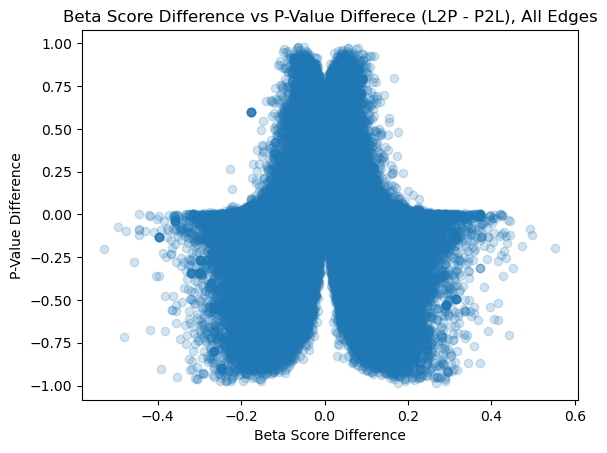

In [27]:
plt.scatter(all_merged['beta_score_diff'], all_merged['p_value_diff'], alpha=0.2)
plt.title("Beta Score Difference vs P-Value Differece (L2P - P2L), All Edges")
plt.xlabel("Beta Score Difference")
plt.ylabel("P-Value Difference")

In [28]:
very_diff_p_value[(very_diff_p_value['p_value_l2p'] < 0.05) | (very_diff_p_value["p_value_p2l"] < 0.05)]

,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff,TF,Gene,z_score_l2p,z_score_p2l,z_score_diff,l2p_rank,p2l_rank,rank_diff,abs_rank_diff
edge,,,,,,,,,,,,,,,
E2F7_MIR1-1,-0.000683,0.993427,-0.054096,0.038389,0.053413,0.955038,E2F7,MIR1-1,0.003259,-1.950421,1.953680,164616.0,9926.0,154690.0,154690.0
EVX2_MIR1-1,0.015347,0.846212,0.047854,0.032523,-0.032507,0.813690,EVX2,MIR1-1,0.169169,1.759686,-1.590517,189230.0,313642.0,-124412.0,124412.0
SNAI3_MIR1-1,0.016025,0.861952,0.052583,0.047979,-0.036558,0.813973,SNAI3,MIR1-1,0.176192,1.931794,-1.755602,190231.0,316581.0,-126350.0,126350.0
ZNF45_MIR1-1,-0.006658,0.913381,0.039498,0.043765,-0.046156,0.869617,ZNF45,MIR1-1,-0.058588,1.455616,-1.514204,155211.0,305913.0,-150702.0,150702.0
ARGFX_MIR100,-0.218260,0.048000,-0.002645,0.934352,-0.215615,-0.886352,ARGFX,MIR100,-2.248751,-0.078060,-2.170691,5200.0,148542.0,-143342.0,143342.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCRT2_MIR941-3,0.280317,0.035612,0.000862,0.984472,0.279455,-0.948859,SCRT2,MIR941-3,2.911715,0.049588,2.862127,324706.0,171101.0,153605.0,153605.0
ZNF704_MIR941-3,0.351454,0.008244,0.006587,0.876069,0.344867,-0.867825,ZNF704,MIR941-3,3.648010,0.257916,3.390093,326002.0,206022.0,119980.0,119980.0
ZZZ3_MIR941-3,0.302954,0.037868,-0.002921,0.951557,0.305875,-0.913688,ZZZ3,MIR941-3,3.146014,-0.088089,3.234103,325311.0,146879.0,178432.0,178432.0


Text(0, 0.5, 'Beta Score')

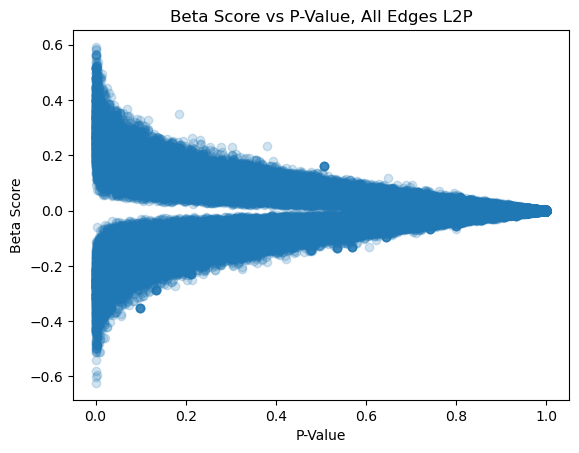

In [29]:
plt.scatter(all_merged['p_value_l2p'], all_merged["beta_score_l2p"], alpha=0.2)
plt.title("Beta Score vs P-Value, All Edges L2P")
plt.xlabel("P-Value")
plt.ylabel("Beta Score")

Text(0, 0.5, 'Beta Score')

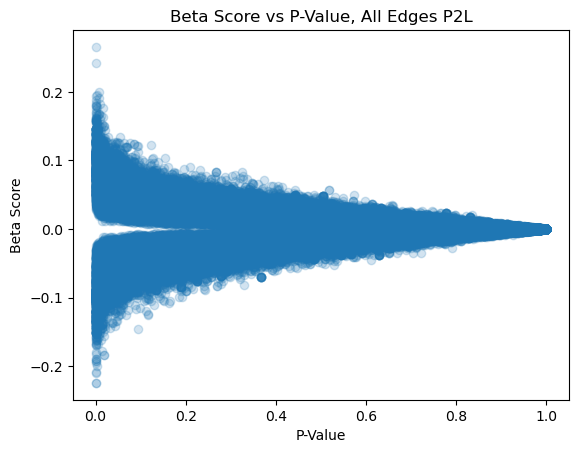

In [30]:
plt.scatter(all_merged['p_value_p2l'], all_merged["beta_score_p2l"], alpha=0.2)
plt.title("Beta Score vs P-Value, All Edges P2L")
plt.xlabel("P-Value")
plt.ylabel("Beta Score")

In [31]:
very_diff_p_value["TF"].value_counts()

TF
KLF5      25
ZNF486    20
ZNF496    19
KLF2      19
ZNF75A    16
          ..
ZNF468     1
TIGD2      1
ZNF580     1
PRDM1      1
HES6       1
Name: count, Length: 741, dtype: int64

Text(0.5, 1.0, 'Beta Score of Edges with Very Different P-Value in L2P vs P2L')

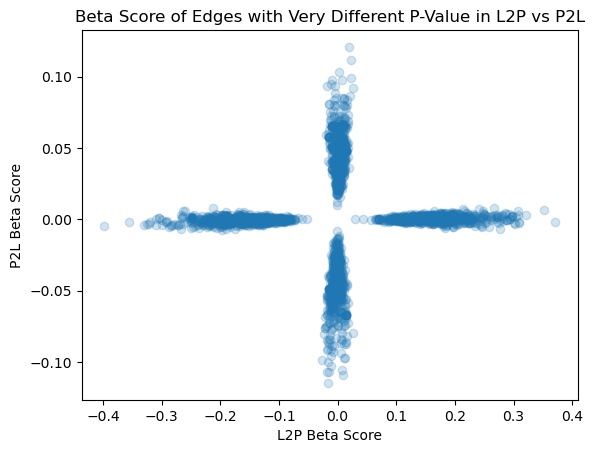

In [32]:
plt.scatter(very_diff_p_value['beta_score_l2p'], very_diff_p_value['beta_score_p2l'], alpha=0.2)
plt.xlabel("L2P Beta Score")
plt.ylabel("P2L Beta Score")
plt.title("Beta Score of Edges with Very Different P-Value in L2P vs P2L")

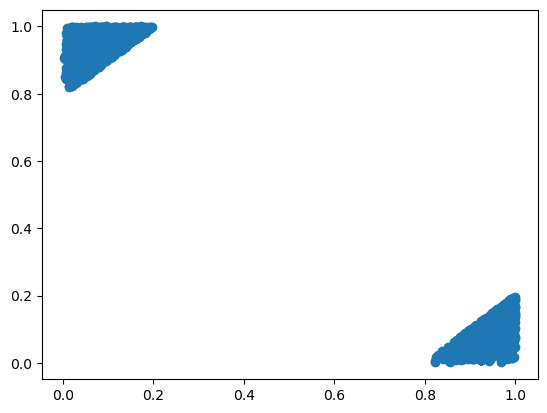

In [33]:
plt.scatter(very_diff_p_value['p_value_l2p'], very_diff_p_value['p_value_p2l'])

In [34]:
# Top 20 Genes with P-Value difference > 0.8
very_diff_p_value["Gene"].value_counts()[0:20]

Gene
MIR877       36
MIR625       32
MIR3909      32
MIR3117      30
MIR425       28
MIR190B      28
MIR20B       28
MIR29C       27
MIR3158-2    26
MIR1266      25
MIR4524A     23
MIR664B      22
MIR423       22
MIR93        21
MIR197       21
MIR449B      21
MIR1270      20
MIR2110      20
MIR495       20
MIR4746      20
Name: count, dtype: int64

In [35]:
# Genes with Beta difference > 0.5
very_diff_beta["Gene"].value_counts()

Gene
MIR100     1
MIR664B    1
Name: count, dtype: int64

In [36]:
# TFs with Beta difference > 0.5
very_diff_beta["TF"].value_counts()

TF
EN1     1
ELK1    1
Name: count, dtype: int64

In [37]:
# Top 20 TFs with P-Value difference > 0.8
very_diff_p_value["TF"].value_counts()[1:20]

TF
ZNF486    20
ZNF496    19
KLF2      19
ZNF75A    16
SP8       14
SCRT1     14
ZNF431    13
DMRTB1    13
SOX14     13
ZNF527    12
ZNF93     12
GLI2      12
GLI3      12
ZNF177    12
ZNF586    12
ZNF740    11
ZNF704    11
NR2E3     11
KLF4      11
Name: count, dtype: int64

In [38]:
sum(abs(l2p_regression['beta_score'] - p2l_regression['beta_score']) > 0.4)

50

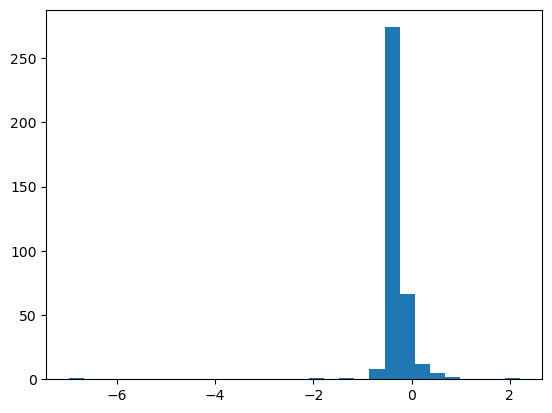

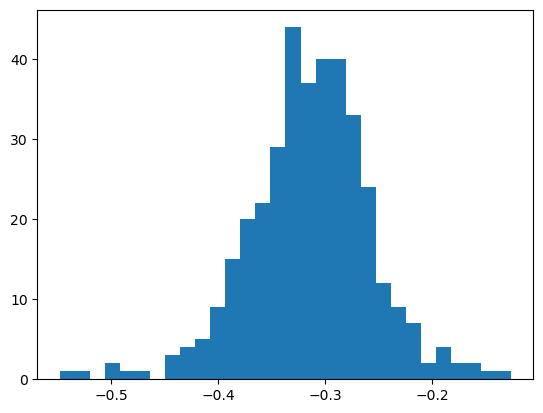

In [39]:
plt.figure()
plt.hist(p2l_merged['HOXD11_MIR449B'], bins=30)
plt.show()

plt.figure()
plt.hist(l2p_merged['HOXD11_MIR449B'], bins=30)
plt.show()


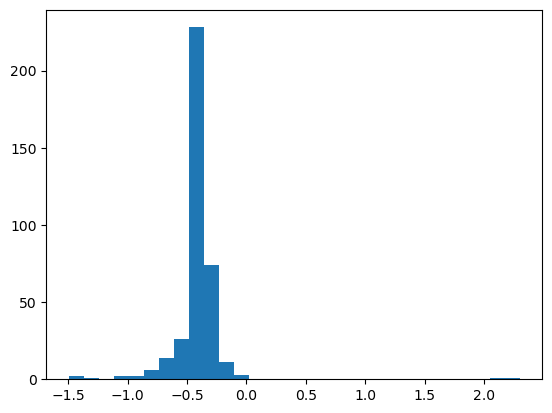

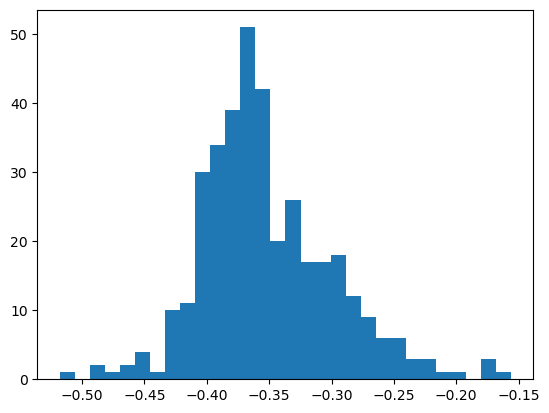

In [40]:
plt.figure()
plt.hist(p2l_merged['RFX7_MIR3688-2'], bins=30)
plt.show()

plt.figure()
plt.hist(l2p_merged['RFX7_MIR3688-2'], bins=30)
plt.show()

(array([4.0000e+00, 4.0000e+00, 7.0000e+00, 1.2000e+01, 5.1000e+01,
        1.3200e+02, 2.8100e+02, 7.1400e+02, 1.6710e+03, 3.9360e+03,
        9.8200e+03, 2.4011e+04, 5.4922e+04, 9.6754e+04, 7.5418e+04,
        3.4978e+04, 1.4232e+04, 5.5900e+03, 2.3090e+03, 8.5700e+02,
        4.4700e+02, 1.8000e+02, 8.3000e+01, 2.7000e+01, 1.0000e+01,
        5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.22447192, -0.20813581, -0.1917997 , -0.17546359, -0.15912748,
        -0.14279137, -0.12645526, -0.11011915, -0.09378304, -0.07744693,
        -0.06111082, -0.0447747 , -0.02843859, -0.01210248,  0.00423363,
         0.02056974,  0.03690585,  0.05324196,  0.06957807,  0.08591418,
         0.10225029,  0.1185864 ,  0.13492251,  0.15125862,  0.16759473,
         0.18393084,  0.20026695,  0.21660306,  0.23293917,  0.24927528,
         0.26561139]),
 <BarContainer object of 30 artists>)

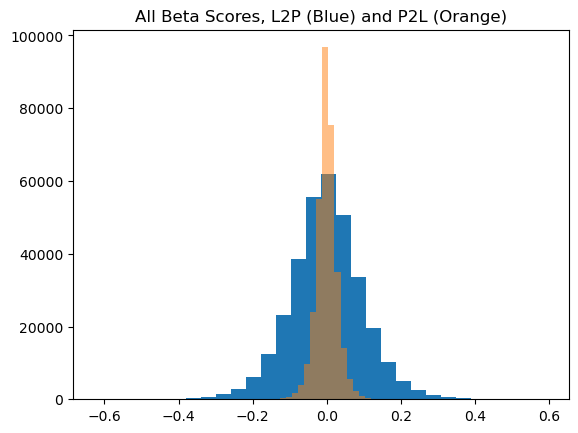

In [41]:
plt.hist(all_merged['beta_score_l2p'], bins=30)
plt.title("All Beta Scores, L2P (Blue) and P2L (Orange)")
plt.hist(all_merged['beta_score_p2l'], bins=30, alpha=0.5)

Text(0, 0.5, 'P2L Score')

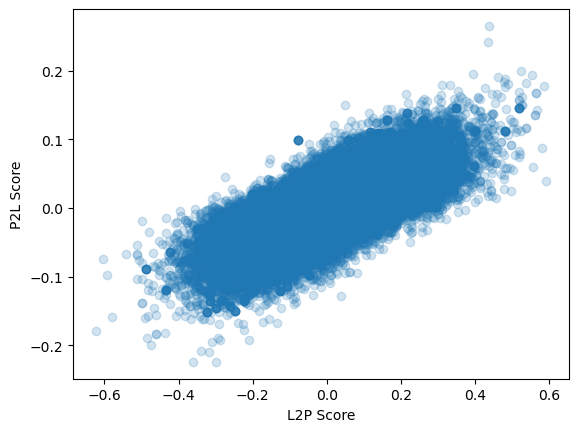

In [42]:
plt.scatter(all_merged['beta_score_l2p'], all_merged['beta_score_p2l'], alpha=0.2)
plt.xlabel("L2P Score")
plt.ylabel("P2L Score")

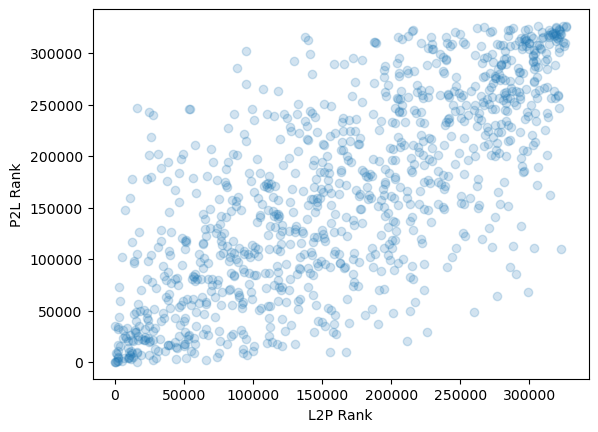

In [43]:
subset = all_merged.sample(n=1000)
plt.scatter(subset['l2p_rank'], subset['p2l_rank'], alpha=.2)
plt.xlabel("L2P Rank")
plt.ylabel("P2L Rank")
plt.show()

Text(0.5, 0, 'Beta Score Rank Difference')

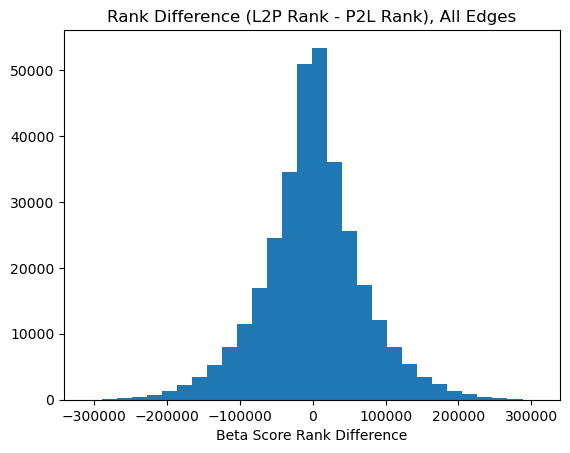

In [44]:
# plt.hist(all_merged.sort_values("abs_rank_diff")['abs_rank_diff'])
plt.hist(all_merged['rank_diff'], bins=30)
plt.title("Rank Difference (L2P Rank - P2L Rank), All Edges")
plt.xlabel("Beta Score Rank Difference")

In [45]:
all_merged[abs(all_merged['rank_diff']) > 200000]

,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff,TF,Gene,z_score_l2p,z_score_p2l,z_score_diff,l2p_rank,p2l_rank,rank_diff,abs_rank_diff
edge,,,,,,,,,,,,,,,
ATF3_MIR1-1,-0.120732,0.200615,0.036491,0.185218,-0.157223,0.015398,ATF3,MIR1-1,-1.239297,1.346185,-2.585481,31543.0,302169.0,-270626.0,270626.0
CREB5_MIR1-1,-0.081305,0.285718,0.022582,0.268957,-0.103887,0.016761,CREB5,MIR1-1,-0.831214,0.839985,-1.671199,59609.0,273911.0,-214302.0,214302.0
EMX2_MIR1-1,-0.065950,0.467866,0.025076,0.347753,-0.091026,0.120114,EMX2,MIR1-1,-0.672284,0.930754,-1.603038,74766.0,280774.0,-206008.0,206008.0
FOSL1_MIR1-1,-0.089295,0.327915,0.025891,0.262759,-0.115187,0.065155,FOSL1,MIR1-1,-0.913917,0.960431,-1.874348,52799.0,282826.0,-230027.0,230027.0
FOSL2_MIR1-1,-0.081305,0.285718,0.022582,0.268957,-0.103887,0.016761,FOSL2,MIR1-1,-0.831214,0.839985,-1.671199,59608.0,273912.0,-214304.0,214304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOXB1_MIR98,-0.103815,0.473905,0.031043,0.410016,-0.134858,0.063889,FOXB1,MIR98,-1.064198,1.147925,-2.212123,41922.0,293812.0,-251890.0,251890.0
HOXA3_MIR98,-0.130822,0.248051,0.017299,0.470231,-0.148121,-0.222180,HOXA3,MIR98,-1.343734,0.647755,-1.991489,26552.0,256529.0,-229977.0,229977.0
IRF6_MIR98,-0.125337,0.372114,0.026234,0.588171,-0.151571,-0.216057,IRF6,MIR98,-1.286963,0.972907,-2.259871,29172.0,283623.0,-254451.0,254451.0


Text(0, 0.5, 'P2L Z-Score')

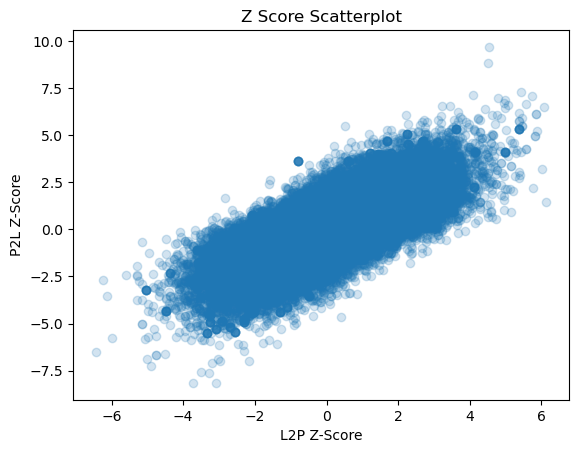

In [46]:
plt.scatter(all_merged['z_score_l2p'], all_merged['z_score_p2l'], alpha=0.2)
plt.title("Z Score Scatterplot")
plt.xlabel("L2P Z-Score")
plt.ylabel("P2L Z-Score")

In [47]:
corr, p_value = pearsonr(all_merged['beta_score_l2p'], all_merged['beta_score_p2l'])
print("Beta score correlation, L2P:P2L")
print(corr)

print("Rank correlation, L2P:P2L")
corr, p_value = pearsonr(all_merged['l2p_rank'], all_merged['p2l_rank'])
print(corr)

print("Z score correlation, L2P:P2L")
corr, p_value = pearsonr(all_merged['z_score_l2p'], all_merged['z_score_p2l'])
print(corr)

Beta score correlation, L2P:P2L
0.7390026635683702
Rank correlation, L2P:P2L
0.7336552690828917
Z score correlation, L2P:P2L
0.7390026635683701


In [48]:
print("Z score correlation")
corr, p_value = pearsonr(all_merged['z_score_l2p'], all_merged['beta_score_l2p'])
print(corr)

Z score correlation
1.0


In [49]:
all_merged.columns

Index(['beta_score_l2p', 'p_value_l2p', 'beta_score_p2l', 'p_value_p2l',
       'beta_score_diff', 'p_value_diff', 'TF', 'Gene', 'z_score_l2p',
       'z_score_p2l', 'z_score_diff', 'l2p_rank', 'p2l_rank', 'rank_diff',
       'abs_rank_diff'],
      dtype='object')

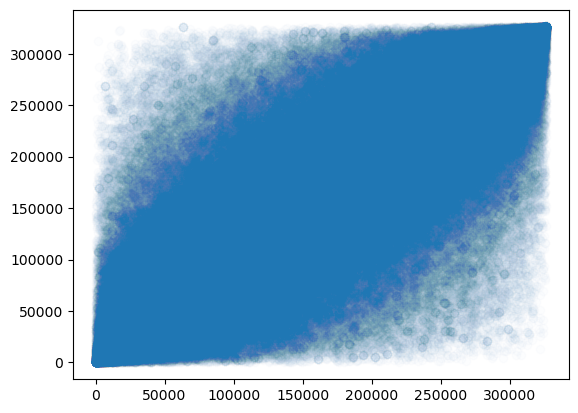

In [50]:
plt.scatter(all_merged['z_score_l2p'].rank(), all_merged['z_score_p2l'].rank(), alpha=0.01)

In [51]:
all_merged[all_merged['abs_rank_diff'] > 300000][1:5]

,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff,TF,Gene,z_score_l2p,z_score_p2l,z_score_diff,l2p_rank,p2l_rank,rank_diff,abs_rank_diff
edge,,,,,,,,,,,,,,,
ATF3_MIR20B,-0.275317,0.064321,0.045861,0.330662,-0.321178,-0.266341,ATF3,MIR20B,-2.839316,1.687151,-4.526467,1642.0,312127.0,-310485.0,310485.0
VAX2_MIR20B,-0.154939,0.439724,0.066248,0.288709,-0.221187,0.151015,VAX2,MIR20B,-1.593358,2.429073,-4.022431,17254.0,321805.0,-304551.0,304551.0
HOXD8_MIR449B,-0.154288,0.402724,0.072120,0.139774,-0.226408,0.262950,HOXD8,MIR449B,-1.586615,2.642772,-4.229387,17474.0,323028.0,-305554.0,305554.0
ZNF595_MIR941-3,0.224592,0.178490,-0.049206,0.334980,0.273798,-0.156490,ZNF595,MIR941-3,2.334935,-1.772468,4.107404,321576.0,13015.0,308561.0,308561.0


Text(0, 0.5, 'L2P Beta Score')

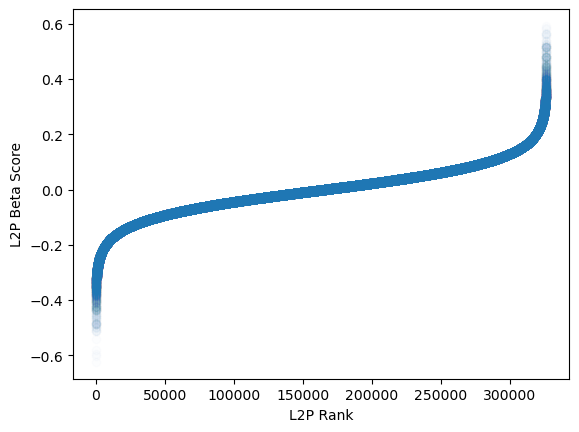

In [52]:
plt.scatter(all_merged['l2p_rank'], all_merged['beta_score_l2p'], alpha=0.01)
plt.xlabel("L2P Rank")
plt.ylabel("L2P Beta Score")

(array([2.0000e+00, 2.0000e+00, 1.2000e+01, 8.0000e+00, 2.7000e+01,
        6.8000e+01, 2.4000e+02, 4.4500e+02, 1.1000e+03, 2.3960e+03,
        5.4260e+03, 1.1567e+04, 2.3441e+04, 4.3561e+04, 6.7619e+04,
        7.0191e+04, 4.8327e+04, 2.6807e+04, 1.3306e+04, 6.3570e+03,
        3.0370e+03, 1.3760e+03, 6.5900e+02, 2.5900e+02, 1.3500e+02,
        4.5000e+01, 2.4000e+01, 1.4000e+01, 3.0000e+00, 3.0000e+00]),
 array([-5.14054051, -4.80030261, -4.4600647 , -4.1198268 , -3.7795889 ,
        -3.43935099, -3.09911309, -2.75887519, -2.41863728, -2.07839938,
        -1.73816148, -1.39792357, -1.05768567, -0.71744777, -0.37720987,
        -0.03697196,  0.30326594,  0.64350384,  0.98374175,  1.32397965,
         1.66421755,  2.00445546,  2.34469336,  2.68493126,  3.02516917,
         3.36540707,  3.70564497,  4.04588288,  4.38612078,  4.72635868,
         5.06659658]),
 <BarContainer object of 30 artists>)

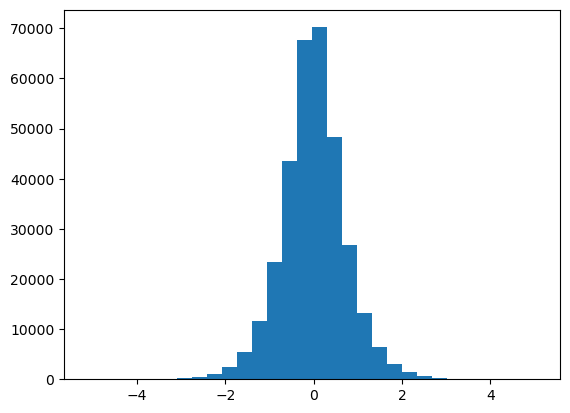

In [53]:
plt.hist(all_merged['z_score_l2p'] - all_merged['z_score_p2l'], bins=30)

Text(0, 0.5, 'Rank Difference (P2L - L2P)')

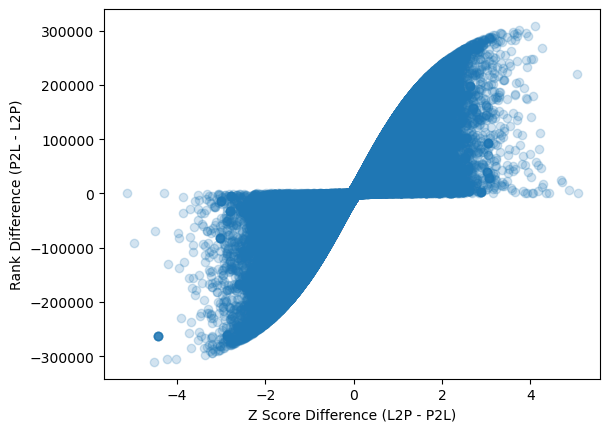

In [54]:
plt.scatter(all_merged['z_score_diff'], all_merged['rank_diff'], alpha=0.2)
plt.xlabel("Z Score Difference (L2P - P2L)")
plt.ylabel("Rank Difference (P2L - L2P)")

Text(0, 0.5, 'Rank Difference (L2P - P2L)')

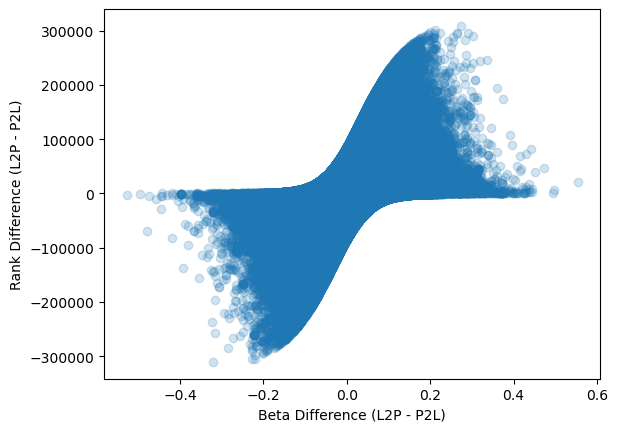

In [55]:
plt.scatter(all_merged['beta_score_diff'], all_merged['rank_diff'], alpha=0.2)
plt.xlabel("Beta Difference (L2P - P2L)")
plt.ylabel("Rank Difference (L2P - P2L)")

Text(0, 0.5, 'Z Score Difference (L2P - P2L)')

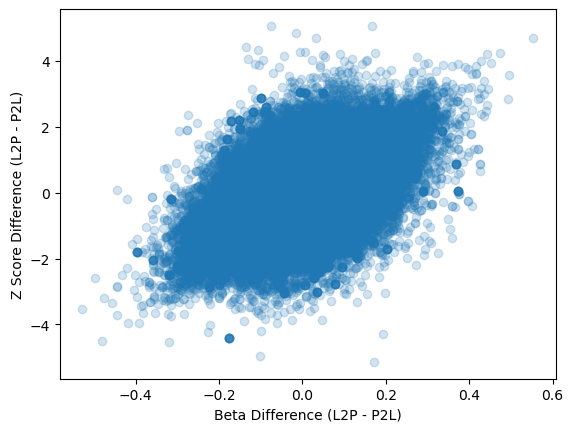

In [56]:
plt.scatter(all_merged['beta_score_diff'], all_merged['z_score_diff'], alpha=0.2)
plt.xlabel("Beta Difference (L2P - P2L)")
plt.ylabel("Z Score Difference (L2P - P2L)")

In [57]:
all_merged[all_merged['z_score_diff'] > 3]



,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff,TF,Gene,z_score_l2p,z_score_p2l,z_score_diff,l2p_rank,p2l_rank,rank_diff,abs_rank_diff
edge,,,,,,,,,,,,,,,
EN1_MIR100,0.592215,0.000419,0.038734,0.193894,0.553481,-0.193475,EN1,MIR100,6.139975,1.427789,4.712185,326457.0,305010.0,21447.0,21447.0
EN1_MIR101-1,0.469721,0.003493,0.049899,0.129459,0.419822,-0.125966,EN1,MIR101-1,4.872121,1.834109,3.038012,326388.0,315024.0,11364.0,11364.0
MYPOP_MIR10B,0.413182,0.003030,0.029667,0.428895,0.383515,-0.425865,MYPOP,MIR10B,4.286914,1.097829,3.189084,326303.0,291085.0,35218.0,35218.0
ZBTB49_MIR10B,0.439890,0.001495,0.036389,0.164396,0.403501,-0.162901,ZBTB49,MIR10B,4.563351,1.342450,3.220902,326349.0,302003.0,24346.0,24346.0
EMX1_MIR1270,0.054736,0.739984,-0.070911,0.065518,0.125647,0.674466,EMX1,MIR1270,0.576861,-2.562356,3.139217,242108.0,4038.0,238070.0,238070.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZBTB49_MIR941-3,0.478664,0.003691,0.042365,0.168640,0.436299,-0.164950,ZBTB49,MIR941-3,4.964680,1.559952,3.404728,326394.0,308901.0,17493.0,17493.0
ZNF595_MIR941-3,0.224592,0.178490,-0.049206,0.334980,0.273798,-0.156490,ZNF595,MIR941-3,2.334935,-1.772468,4.107404,321576.0,13015.0,308561.0,308561.0
ZNF704_MIR941-3,0.351454,0.008244,0.006587,0.876069,0.344867,-0.867825,ZNF704,MIR941-3,3.648010,0.257916,3.390093,326002.0,206022.0,119980.0,119980.0


In [58]:
all_merged[abs(all_merged['z_score_diff']) > 3]["Gene"].value_counts().head(10)

Gene
MIR664B     35
MIR15B      29
MIR20B      21
MIR941-3    17
MIR15A      16
MIR4510     16
MIR449B     15
MIR18A      14
MIR1277     13
MIR1270     12
Name: count, dtype: int64

In [59]:
all_merged[abs(all_merged['z_score_diff']) > 3]["TF"].value_counts().head(10)

TF
SP8        20
GSX1       17
ZNF410     11
ONECUT2    11
ZNF431     11
KLF2       10
EN1         9
DPRX        8
PRRX1       6
LBX1        6
Name: count, dtype: int64

In [60]:
significant_z_score_difference.sort_values("z_score_diff").head(5)

,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff,TF,Gene,z_score_l2p,z_score_p2l,z_score_diff,l2p_rank,p2l_rank,rank_diff,abs_rank_diff,abs_z_score_diff
edge,,,,,,,,,,,,,,,,
ZNF410_MIR139,0.437989,0.000162,0.265611,1.024078e-07,0.172378,0.000162,ZNF410,MIR139,4.543683,9.684223,-5.140541,326346.0,326457.0,-111.0,111.0,5.140541
GSX1_MIR1277,0.049415,0.759876,0.150442,5.865551e-03,-0.101027,0.754011,GSX1,MIR1277,0.521784,5.493024,-4.971240,235753.0,326410.0,-90657.0,90657.0,4.971240
ATF3_MIR20B,-0.275317,0.064321,0.045861,3.306625e-01,-0.321178,-0.266341,ATF3,MIR20B,-2.839316,1.687151,-4.526467,1642.0,312127.0,-310485.0,310485.0,4.526467
ATF7_MIR20B,-0.498493,0.003995,-0.018335,7.230693e-01,-0.480158,-0.719074,ATF7,MIR20B,-5.149268,-0.649023,-4.500245,15.0,69388.0,-69373.0,69373.0,4.500245
ISX_MIR1277,-0.076993,0.617360,0.099517,2.127602e-02,-0.176510,0.596084,ISX,MIR1277,-0.786588,3.639773,-4.426361,63613.0,325610.0,-261997.0,261997.0,4.426361


In [61]:
significant_z_score_difference[abs(significant_z_score_difference['z_score_diff']) > 3]['Gene'].value_counts().head(10)

Gene
MIR664B     35
MIR15B      29
MIR20B      21
MIR941-3    17
MIR15A      16
MIR4510     16
MIR449B     15
MIR18A      14
MIR1277     13
MIR1270     12
Name: count, dtype: int64

In [62]:
significant_z_score_difference[abs(significant_z_score_difference['z_score_diff']) > 3]['TF'].value_counts().head(10)

TF
SP8        20
GSX1       17
ZNF410     11
ONECUT2    11
ZNF431     11
KLF2       10
EN1         9
DPRX        8
PRRX1       6
LBX1        6
Name: count, dtype: int64

In [63]:
significant_z_score_difference[abs(significant_z_score_difference['z_score_diff']) > 4]['Gene'].value_counts().head(10)

Gene
MIR1277     10
MIR4510      3
MIR664B      3
MIR20B       3
MIR144       3
MIR449A      2
MIR941-3     2
MIR326       2
MIR100       1
MIR139       1
Name: count, dtype: int64

In [64]:
significant_z_score_difference[abs(significant_z_score_difference['z_score_diff']) > 4]['TF'].value_counts().head(10)

TF
DPRX      4
ZNF431    3
ZNF410    3
GSX1      2
DMBX1     2
ISX       1
EN1       1
DLX6      1
PRRX1     1
LHX8      1
Name: count, dtype: int64

In [65]:
significant_z_score_difference[significant_z_score_difference['z_score_diff'] < -4].shape

(17, 16)

(array([  2.,   0.,  11.,   3.,   6.,  13.,  27.,  57.,  49.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  17., 113.,
         45.,  26.,  20.,  13.,   2.,   2.,   3.]),
 array([-5.14054051, -4.88536208, -4.63018365, -4.37500523, -4.1198268 ,
        -3.86464837, -3.60946994, -3.35429152, -3.09911309, -2.84393466,
        -2.58875624, -2.33357781, -2.07839938, -1.82322095, -1.56804253,
        -1.3128641 , -1.05768567, -0.80250724, -0.54732882, -0.29215039,
        -0.03697196,  0.21820647,  0.47338489,  0.72856332,  0.98374175,
         1.23892017,  1.4940986 ,  1.74927703,  2.00445546,  2.25963388,
         2.51481231,  2.76999074,  3.02516917,  3.28034759,  3.53552602,
         3.79070445,  4.04588288,  4.3010613 ,  4.55623973,  4.81141816,
         5.06659658]),
 <BarContainer object of 40 artists>)

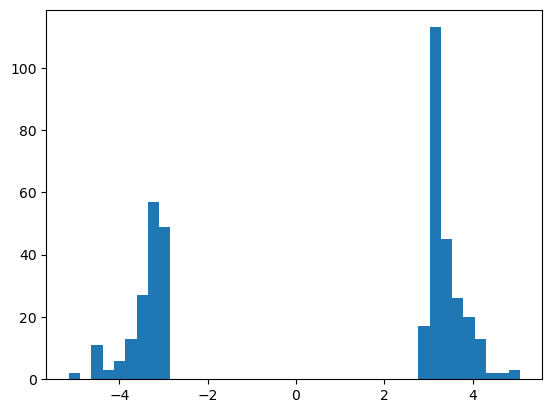

In [66]:
plt.hist(significant_z_score_difference['z_score_diff'], bins=40)

In [103]:
significant_z_score_difference

,beta_score_l2p,p_value_l2p,beta_score_p2l,p_value_p2l,beta_score_diff,p_value_diff,TF,Gene,z_score_l2p,z_score_p2l,z_score_diff,l2p_rank,p2l_rank,rank_diff,abs_rank_diff,abs_z_score_diff
edge,,,,,,,,,,,,,,,,
ATF3_MIR100,0.044617,0.737144,0.105004,0.041608,-0.060387,0.695536,ATF3,MIR100,0.472131,3.839484,-3.367352,229753.0,325797.0,-96044.0,96044.0,3.367352
EN1_MIR100,0.592215,0.000419,0.038734,0.193894,0.553481,-0.193475,EN1,MIR100,6.139975,1.427789,4.712185,326457.0,305010.0,21447.0,21447.0,4.712185
ATF3_MIR101-1,-0.047487,0.713875,0.093668,0.048572,-0.141155,0.665303,ATF3,MIR101-1,-0.481185,3.426931,-3.908116,96172.0,325335.0,-229163.0,229163.0,3.908116
EN1_MIR101-1,0.469721,0.003493,0.049899,0.129459,0.419822,-0.125966,EN1,MIR101-1,4.872121,1.834109,3.038012,326388.0,315024.0,11364.0,11364.0,3.038012
GSX1_MIR106A,0.022706,0.873654,0.111561,0.041124,-0.088856,0.832530,GSX1,MIR106A,0.245334,4.078088,-3.832753,200127.0,326016.0,-125889.0,125889.0,3.832753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF595_MIR941-3,0.224592,0.178490,-0.049206,0.334980,0.273798,-0.156490,ZNF595,MIR941-3,2.334935,-1.772468,4.107404,321576.0,13015.0,308561.0,308561.0,4.107404
ZNF704_MIR941-3,0.351454,0.008244,0.006587,0.876069,0.344867,-0.867825,ZNF704,MIR941-3,3.648010,0.257916,3.390093,326002.0,206022.0,119980.0,119980.0,3.390093
ZNF764_MIR941-3,-0.036294,0.776106,-0.126408,0.006674,0.090115,0.769432,ZNF764,MIR941-3,-0.365332,-4.581998,4.216666,111061.0,211.0,110850.0,110850.0,4.216666


In [88]:
significant_z_score_difference_sorted[0:10][['beta_score_l2p', 'beta_score_p2l', 'z_score_l2p', 'z_score_p2l', 'z_score_diff', 'abs_z_score_diff']]
# significant_z_score_difference_sorted[10:20][['beta_score_l2p', 'beta_score_p2l', 'z_score_l2p', 'z_score_p2l', 'z_score_diff', 'abs_z_score_diff']]

,beta_score_l2p,beta_score_p2l,z_score_l2p,z_score_p2l,z_score_diff,abs_z_score_diff
edge,,,,,,
ZNF410_MIR139,0.437989,0.265611,4.543683,9.684223,-5.140541,5.140541
DPRX_MIR326,-0.298966,-0.224472,-3.084087,-8.150683,5.066597,5.066597
ZNF431_MIR664B,0.036951,-0.128785,0.392779,-4.668480,5.061260,5.061260
GSX1_MIR1277,0.049415,0.150442,0.521784,5.493024,-4.971240,4.971240
ZNF410_MIR335,-0.208908,-0.193204,-2.151960,-7.012803,4.860843,4.860843
EN1_MIR100,0.592215,0.038734,6.139975,1.427789,4.712185,4.712185
TP73_MIR4510,-0.134704,-0.167323,-1.383911,-6.070961,4.687050,4.687050
ATF3_MIR20B,-0.275317,0.045861,-2.839316,1.687151,-4.526467,4.526467
ATF7_MIR20B,-0.498493,-0.018335,-5.149268,-0.649023,-4.500245,4.500245


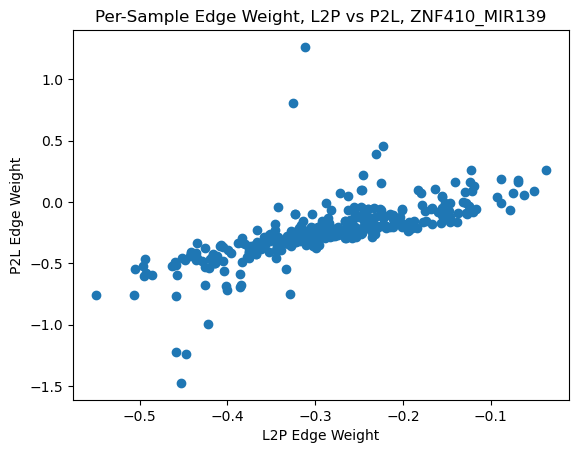

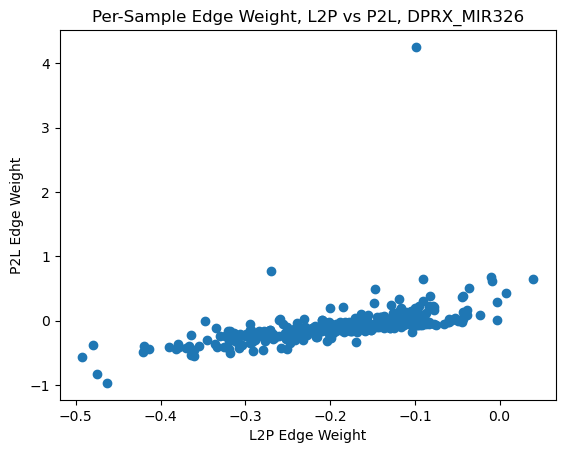

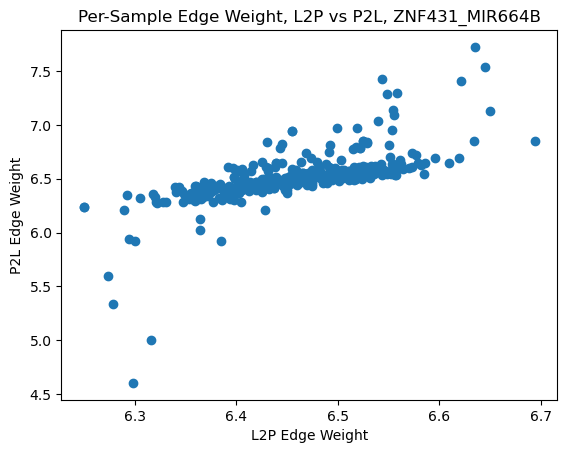

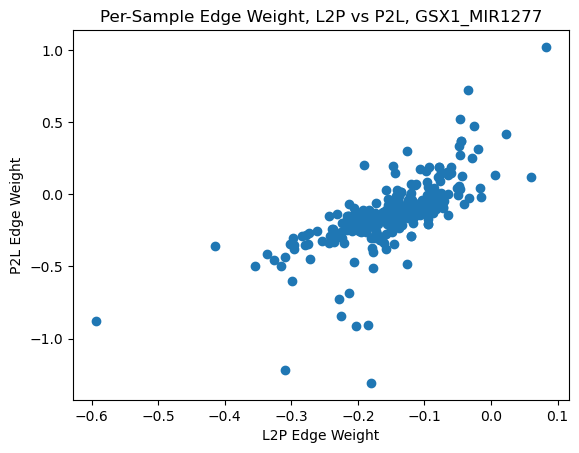

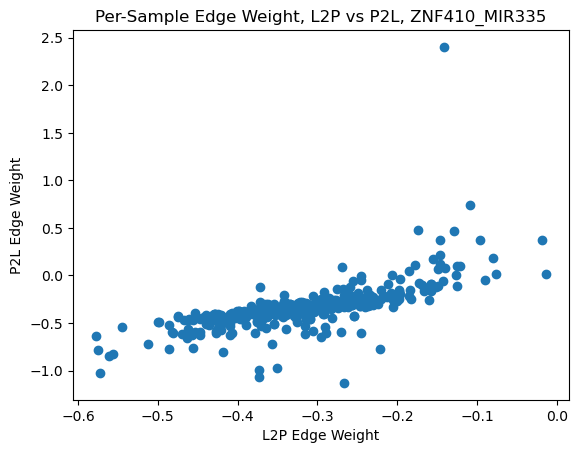

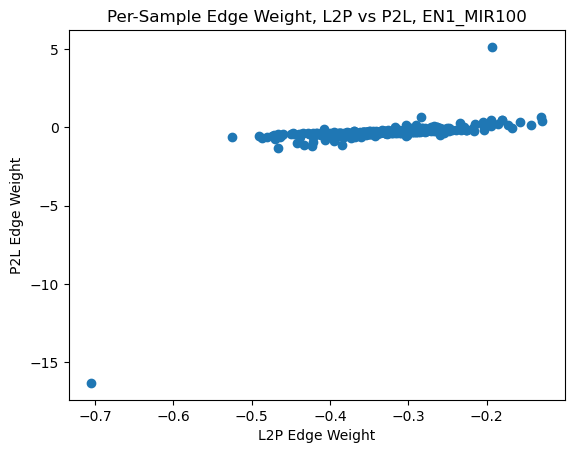

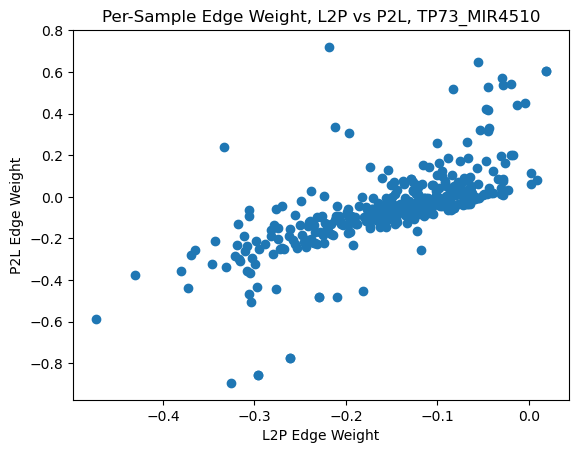

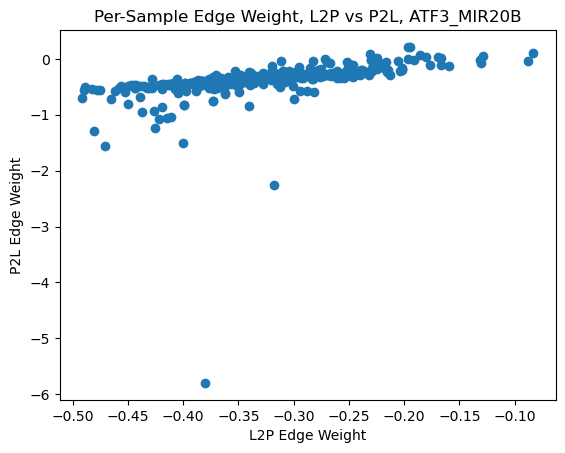

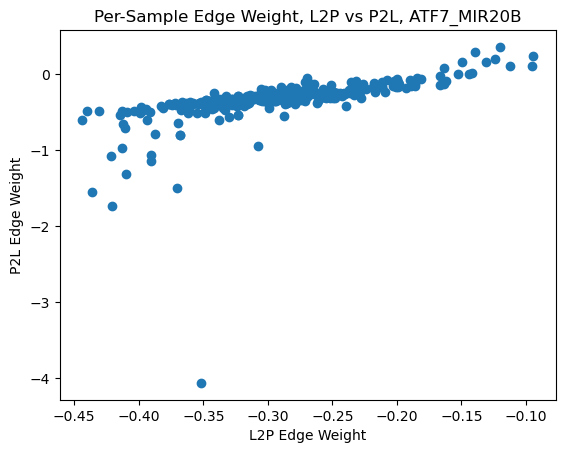

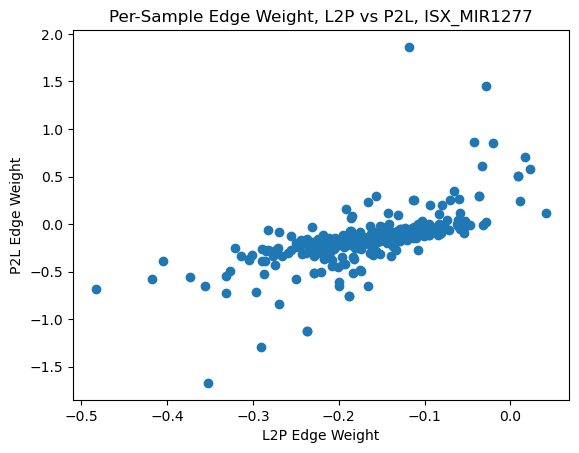

In [68]:
for edge in analyze:
    plt.scatter(l2p_merged[edge], p2l_merged[edge])
    plt.xlabel("L2P Edge Weight")
    plt.ylabel("P2L Edge Weight")
    plt.title(f"Per-Sample Edge Weight, L2P vs P2L, {edge}")
    plt.show()

In [69]:
sum(significant_z_score_difference['z_score_diff'] < 0)

168

(array([3.0000e+00, 1.0000e+00, 6.0000e+00, 2.7000e+01, 5.0000e+01,
        9.1000e+01, 2.5100e+02, 5.5100e+02, 1.3270e+03, 2.8660e+03,
        6.0020e+03, 1.2378e+04, 2.3294e+04, 3.8454e+04, 5.5706e+04,
        6.1913e+04, 5.0760e+04, 3.3617e+04, 1.9483e+04, 1.0123e+04,
        4.8990e+03, 2.4560e+03, 1.1780e+03, 5.3700e+02, 2.4500e+02,
        1.1400e+02, 5.7000e+01, 3.4000e+01, 2.4000e+01, 1.0000e+01]),
 array([-6.44724277, -6.02766885, -5.60809494, -5.18852103, -4.76894712,
        -4.34937321, -3.9297993 , -3.51022539, -3.09065148, -2.67107757,
        -2.25150366, -1.83192975, -1.41235583, -0.99278192, -0.57320801,
        -0.1536341 ,  0.26593981,  0.68551372,  1.10508763,  1.52466154,
         1.94423545,  2.36380936,  2.78338328,  3.20295719,  3.6225311 ,
         4.04210501,  4.46167892,  4.88125283,  5.30082674,  5.72040065,
         6.13997456]),
 <BarContainer object of 30 artists>)

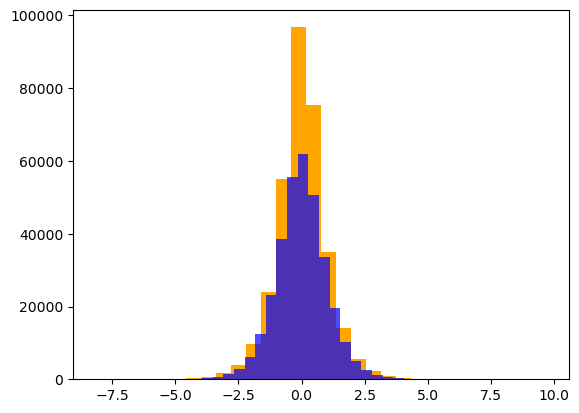

In [70]:
plt.hist(all_merged['z_score_p2l'], bins=30, color="orange")
plt.hist(all_merged['z_score_l2p'], bins=30, alpha=0.7,color="blue")
